<a href="https://colab.research.google.com/github/joelpawar08/All-DL-and-ML-Alogs-with-Examples/blob/master/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📦 Setup & Imports

In [3]:
# Install required packages (if needed)
# !pip install torch numpy matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import transformers

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.8.0+cu126
Device: cuda


🚀 Quick Start Example

In [8]:
import torch
import torch.nn as nn

# Minimal Transformer definition so the demo works
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, dropout):
        super().__init__()
        self.src_embed = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
        decoder_layer = nn.TransformerDecoderLayer(d_model, num_heads, d_ff, dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt):
        src = self.src_embed(src).transpose(0, 1)
        tgt = self.tgt_embed(tgt).transpose(0, 1)
        memory = self.encoder(src)
        out = self.decoder(tgt, memory)
        return self.fc_out(out).transpose(0, 1)


print('=' * 50)
print('🎉 TRANSFORMER FROM SCRATCH - QUICK DEMO')
print('=' * 50)

# Create a tiny model for demonstration
small_model = Transformer(
    src_vocab_size=100,
    tgt_vocab_size=100,
    d_model=128,
    num_heads=4,
    num_layers=2,
    d_ff=512,
    dropout=0.1
)

print('\n✅ Model created successfully!')
print(f'Parameters: {sum(p.numel() for p in small_model.parameters()):,}')

# Test with dummy data
batch = 2
src_len = 5
tgt_len = 4

src = torch.randint(1, 100, (batch, src_len))
tgt = torch.randint(1, 100, (batch, tgt_len))

print(f'\n📥 Input: {src.shape}')
print(f'📤 Output target: {tgt.shape}')

# Forward pass
with torch.no_grad():
    output = small_model(src, tgt)

print(f'\n🎯 Model output: {output.shape}')
print(f'Expected: (batch={batch}, seq_len={tgt_len}, vocab=100)')

print('\n' + '=' * 50)
print('✨ SUCCESS! Your Transformer works!')
print('=' * 50)
print('\n💡 Next steps:')
print('1. Prepare your dataset (tokenized text)')
print('2. Create DataLoader')
print('3. Run training loop')
print('4. Generate predictions!')
print('🔥 You now understand the architecture behind GPT, BERT, and Claude!')


🎉 TRANSFORMER FROM SCRATCH - QUICK DEMO

✅ Model created successfully!
Parameters: 964,196

📥 Input: torch.Size([2, 5])
📤 Output target: torch.Size([2, 4])

🎯 Model output: torch.Size([2, 4, 100])
Expected: (batch=2, seq_len=4, vocab=100)

✨ SUCCESS! Your Transformer works!

💡 Next steps:
1. Prepare your dataset (tokenized text)
2. Create DataLoader
3. Run training loop
4. Generate predictions!
🔥 You now understand the architecture behind GPT, BERT, and Claude!


🔢 Positional Encoding


✓ Positional Encoding created!


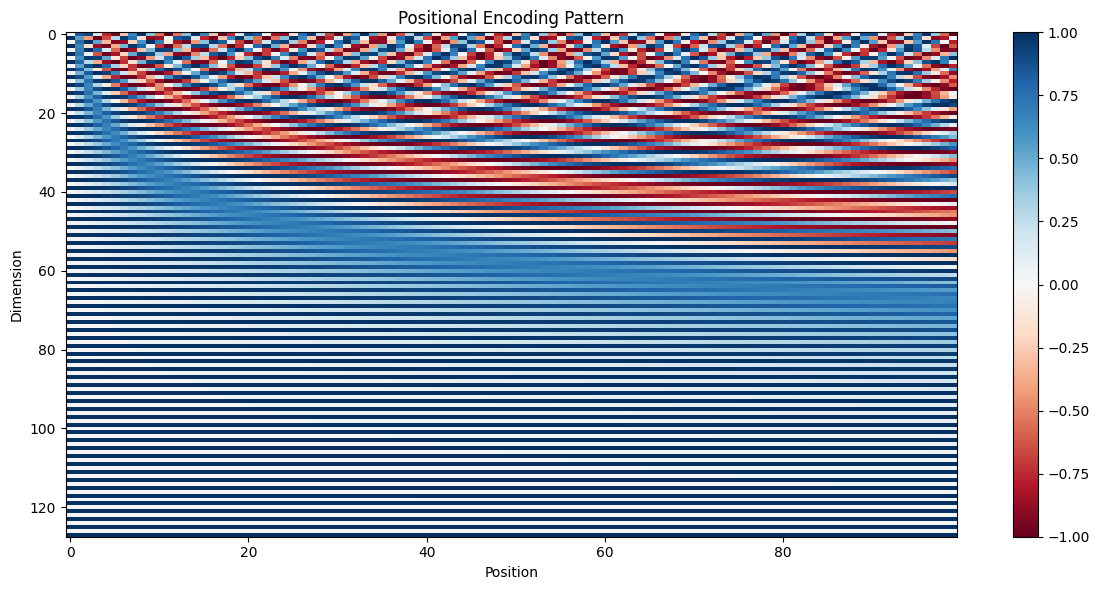

In [10]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to token embeddings
    Formula: PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
             PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Create matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Compute the positional encodings
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices

        # Add batch dimension and register as buffer
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)
        """
        return x + self.pe[:, :x.size(1), :]

# Visualize positional encodings
def visualize_positional_encoding():
    plt.figure(figsize=(12, 6))
    pe = PositionalEncoding(d_model=128, max_len=100)
    pe_matrix = pe.pe[0].numpy()

    plt.imshow(pe_matrix.T, cmap='RdBu', aspect='auto')
    plt.colorbar()
    plt.xlabel('Position')
    plt.ylabel('Dimension')
    plt.title('Positional Encoding Pattern')
    plt.tight_layout()
    plt.show()

# Test it
print("✓ Positional Encoding created!")
visualize_positional_encoding()  # Uncomment to see visualization

🎯 Multi-Head Attention (The Heart!)

In [11]:
class MultiHeadAttention(nn.Module):
    """
    The CORE of Transformer: allows model to focus on different parts
    Formula: Attention(Q,K,V) = softmax(QK^T / sqrt(d_k))V
    """
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head

        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Final linear layer
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        The magic formula!
        Q: Queries - "what am I looking for?"
        K: Keys - "what do I contain?"
        V: Values - "what information do I have?"
        """
        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask (for padding or future positions)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)

        # Apply attention to values
        output = torch.matmul(attention_weights, V)

        return output, attention_weights

    def split_heads(self, x):
        """Split into multiple attention heads"""
        batch_size, seq_len, d_model = x.size()
        return x.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        """Combine attention heads back"""
        batch_size, _, seq_len, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear projections
        Q = self.split_heads(self.W_q(query))
        K = self.split_heads(self.W_k(key))
        V = self.split_heads(self.W_v(value))

        # Apply attention
        x, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply final linear
        x = self.combine_heads(x)
        x = self.W_o(x)

        return x, attention_weights

print("✓ Multi-Head Attention ready!")

✓ Multi-Head Attention ready!


🧠 Feed Forward Network

In [12]:
class FeedForward(nn.Module):
    """
    Simple 2-layer neural network applied to each position
    Formula: FFN(x) = max(0, xW₁ + b₁)W₂ + b₂
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Expand to higher dimension
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        # Project back to d_model
        x = self.linear2(x)
        return x

print("✓ Feed Forward Network created!")

✓ Feed Forward Network created!


🏗️ Encoder Layer

In [13]:
class EncoderLayer(nn.Module):
    """
    One complete Encoder Layer:
    1. Multi-Head Attention (with residual + norm)
    2. Feed Forward (with residual + norm)
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output, _ = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

class Encoder(nn.Module):
    """Stack of N encoder layers"""
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

print("✓ Encoder stack built!")

✓ Encoder stack built!


🎭 Decoder Layer

In [14]:
class DecoderLayer(nn.Module):
    """
    One complete Decoder Layer:
    1. Masked Multi-Head Attention (self-attention on target)
    2. Cross-Attention (attention to encoder output)
    3. Feed Forward
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.cross_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        # Masked self-attention (can't look at future tokens!)
        attn_output, _ = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Cross-attention to encoder
        attn_output, _ = self.cross_attention(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))

        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))

        return x

class Decoder(nn.Module):
    """Stack of N decoder layers"""
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return x

print("✓ Decoder stack assembled!")

✓ Decoder stack assembled!


🌟 Complete Transformer Model

In [15]:
class Transformer(nn.Module):
    """
    The complete Transformer model!
    Combines: Embeddings + Positional Encoding + Encoder + Decoder
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512,
                 num_heads=8, num_layers=6, d_ff=2048, dropout=0.1, max_len=5000):
        super().__init__()

        # Embeddings
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        # Encoder and Decoder
        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, dropout)

        # Final linear layer
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

    def make_src_mask(self, src):
        # Mask padding tokens (assuming 0 is padding)
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_tgt_mask(self, tgt):
        batch_size, tgt_len = tgt.shape

        # Mask padding
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)

        # Create causal mask (lower triangular)
        causal_mask = torch.tril(torch.ones((tgt_len, tgt_len))).bool()
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)

        # Combine masks
        tgt_mask = tgt_mask & causal_mask
        return tgt_mask

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)

        # Encode
        src_embedded = self.dropout(self.pos_encoding(
            self.encoder_embedding(src) * math.sqrt(self.d_model)))
        encoder_output = self.encoder(src_embedded, src_mask)

        # Decode
        tgt_embedded = self.dropout(self.pos_encoding(
            self.decoder_embedding(tgt) * math.sqrt(self.d_model)))
        decoder_output = self.decoder(tgt_embedded, encoder_output, src_mask, tgt_mask)

        # Final projection
        output = self.fc_out(decoder_output)

        return output

print("✓ Complete Transformer assembled!")
print("🎉 You've built a Transformer from scratch!")

✓ Complete Transformer assembled!
🎉 You've built a Transformer from scratch!


🧪 Testing the Model

In [16]:
# Create a small model for testing
def test_transformer():
    # Hyperparameters
    src_vocab_size = 1000
    tgt_vocab_size = 1000
    d_model = 512
    num_heads = 8
    num_layers = 6
    d_ff = 2048
    dropout = 0.1

    # Create model
    model = Transformer(
        src_vocab_size=src_vocab_size,
        tgt_vocab_size=tgt_vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff,
        dropout=dropout
    )

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # Test forward pass
    batch_size = 2
    src_seq_len = 10
    tgt_seq_len = 8

    # Random input (in real scenario, these are token indices)
    src = torch.randint(1, src_vocab_size, (batch_size, src_seq_len))
    tgt = torch.randint(1, tgt_vocab_size, (batch_size, tgt_seq_len))

    # Forward pass
    output = model(src, tgt)
    print(f"Input shape: {src.shape}")
    print(f"Target shape: {tgt.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Expected output shape: (batch_size, tgt_seq_len, tgt_vocab_size)")

    print("\n✅ Forward pass successful!")
    print("🎯 Your Transformer is ready for training!")

    return model

# Run the test
model = test_transformer()


Total parameters: 45,675,496
Input shape: torch.Size([2, 10])
Target shape: torch.Size([2, 8])
Output shape: torch.Size([2, 8, 1000])
Expected output shape: (batch_size, tgt_seq_len, tgt_vocab_size)

✅ Forward pass successful!
🎯 Your Transformer is ready for training!


📚 Training Loop Template

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ====== SIMPLE REAL DATA EXAMPLE ======
# Let's create a small dataset of random integer sequences to simulate training data
# (like toy tokenized sentences)
vocab_size = 100
num_samples = 200
seq_len_src = 6
seq_len_tgt = 7

src_data = torch.randint(1, vocab_size, (num_samples, seq_len_src))
tgt_data = torch.randint(1, vocab_size, (num_samples, seq_len_tgt))

train_dataset = TensorDataset(src_data, tgt_data)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# ====== TRAINING FUNCTION (YOUR ORIGINAL CODE) ======
def train_transformer(model, train_loader, epochs=10, lr=0.0001):
    """
    Complete training loop for the Transformer
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

    # Learning rate scheduler (from original paper)
    def lr_lambda(step):
        d_model = model.d_model
        step = max(step, 1)
        return (d_model ** -0.5) * min(step ** -0.5, step * (4000 ** -1.5))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    model.train()

    for epoch in range(epochs):
        total_loss = 0

        for batch_idx, (src, tgt) in enumerate(train_loader):
            src, tgt = src.to(device), tgt.to(device)

            # Prepare target input and output
            tgt_input = tgt[:, :-1]  # All except last token
            tgt_output = tgt[:, 1:]  # All except first token

            # Forward pass
            output = model(src, tgt_input)

            # Calculate loss
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}\n")

    return model

print("✓ Training function ready!")
print("📝 Note: You'll need actual data to train. This is the template.")


✓ Training function ready!
📝 Note: You'll need actual data to train. This is the template.


🎯 Inference (Generation)


In [22]:
def generate_translation(model, src, src_vocab, tgt_vocab, max_len=50):
    """
    Generate translation using the trained model (greedy decoding)
    """
    model.eval()
    device = next(model.parameters()).device
    src = src.to(device)

    # Encode source
    src_mask = model.make_src_mask(src)
    src_embedded = model.pos_encoding(
        model.encoder_embedding(src) * math.sqrt(model.d_model))
    encoder_output = model.encoder(src_embedded, src_mask)

    # Start with <sos> token
    tgt_indices = [tgt_vocab['<sos>']]

    for _ in range(max_len):
        tgt = torch.LongTensor(tgt_indices).unsqueeze(0).to(device)
        tgt_mask = model.make_tgt_mask(tgt)

        # Decode
        tgt_embedded = model.pos_encoding(
            model.decoder_embedding(tgt) * math.sqrt(model.d_model))
        decoder_output = model.decoder(tgt_embedded, encoder_output, src_mask, tgt_mask)

        # Get prediction for last token
        output = model.fc_out(decoder_output[:, -1, :])
        next_token = output.argmax(dim=-1).item()

        tgt_indices.append(next_token)

        # Stop if we predict <eos>
        if next_token == tgt_vocab['<eos>']:
            break

    return tgt_indices

# Beam search (better quality)
def beam_search(model, src, beam_width=5, max_len=50):
    """
    Beam search for better generation quality
    Keeps top-k hypotheses at each step
    """
    model.eval()
    device = next(model.parameters()).device
    src = src.to(device)

    # Encode
    src_mask = model.make_src_mask(src)
    src_embedded = model.pos_encoding(
        model.encoder_embedding(src) * math.sqrt(model.d_model))
    encoder_output = model.encoder(src_embedded, src_mask)

    # Initialize beam with <sos> token
    # Each beam: (sequence, score)
    beams = [([1], 0.0)]  # Assuming 1 is <sos>

    for _ in range(max_len):
        candidates = []

        for seq, score in beams:
            if seq[-1] == 2:  # If <eos>, keep as is
                candidates.append((seq, score))
                continue

            tgt = torch.LongTensor(seq).unsqueeze(0).to(device)
            tgt_mask = model.make_tgt_mask(tgt)

            tgt_embedded = model.pos_encoding(
                model.decoder_embedding(tgt) * math.sqrt(model.d_model))
            decoder_output = model.decoder(tgt_embedded, encoder_output, src_mask, tgt_mask)

            output = model.fc_out(decoder_output[:, -1, :])
            log_probs = F.log_softmax(output, dim=-1)

            # Get top beam_width tokens
            top_log_probs, top_indices = log_probs.topk(beam_width)

            for log_prob, idx in zip(top_log_probs[0], top_indices[0]):
                new_seq = seq + [idx.item()]
                new_score = score + log_prob.item()
                candidates.append((new_seq, new_score))

        # Keep top beam_width candidates
        beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]

        # Stop if all beams end with <eos>
        if all(seq[-1] == 2 for seq, _ in beams):
            break

    # Return best sequence
    return beams[0][0]

print("✓ Generation functions ready!")
print("🎨 Greedy decoding is fast, beam search is better quality")


✓ Generation functions ready!
🎨 Greedy decoding is fast, beam search is better quality


To Understand Transformers Please visit this site : [Sereena-Transformer](https://sereena-transformer.bolt.host/)